# Creating a Simple Neural Network with PyTorch 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

## Loading and Visualizing MNIST Dataset 

In [2]:
from torchvision import datasets, transforms as T

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

In [4]:
trainset = datasets.MNIST('MNIST_data/', download=False, train = True, transform= transform)

testset = datasets.MNIST('MNIST_data/', download=False, train = False, transform= transform)

In [5]:
print(f'Size of train set : {len(trainset)}')

Size of train set : 60000


In [6]:
print(f'Size of test set : {len(testset)}')

Size of test set : 10000


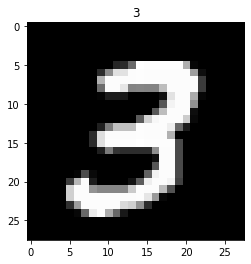

In [7]:
idx = 7
image, label = trainset[idx]
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.title(label);

## Splitting Dataset and Setting DataLoader Into Train,Test and Validation Set

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
valid_size = 0.2
num_train = len(trainset)
split = int(np.floor(valid_size*num_train))

indices = list(range(num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

In [10]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [11]:
trainloader = DataLoader(trainset, batch_size=64, sampler= train_sampler)

validloader = DataLoader(trainset, batch_size=64, sampler= valid_sampler)

testloader = DataLoader(testset, batch_size=64, shuffle = True)

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [13]:
print(f"Batches in train loader : {len(trainloader)} ")
print(f"Batches in valid loader : {len(validloader)} ")
print(f"Batches in test loader : {len(testloader)} ")

Batches in train loader : 750 
Batches in valid loader : 188 
Batches in test loader : 157 


In [14]:
print(f"Total Examples in train loader : {len(trainloader.sampler)} ")
print(f"Total Examples in valid loader : {len(validloader.sampler)} ")
print(f"Total Examples in test loader : {len(testloader.dataset)} ")

Total Examples in train loader : 48000 
Total Examples in valid loader : 12000 
Total Examples in test loader : 10000 


## Creating Neural Network or Model

In [15]:
from torch import nn
import torch.nn.functional as F

In [33]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier,self).__init__()

        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,10)
        #droput layer to prevent overfitiing
        self.dropout = nn.Dropout(0.4)

    def forward(self, images):
        # convert images into input feature dimension
        # [64,1,28,28] -> [64, 784]
        images = images.view(images.shape[0], -1)

        # First layer
        z1 = self.linear1(images)
        a1 = self.dropout(F.relu(z1))

        # Second Layer
        z2 = self.linear2(a1)
        a2 = self.dropout(F.relu(z2))

        # Third layer
        z3 = self.linear3(a2)
        a3 = F.log_softmax(z3, dim=1)

        return a3

In [34]:
model = Classifier()
print(model)

Classifier(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [35]:
from torchsummary import summary

In [36]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


## Traing the Neural Network

In [37]:
from torch import optim
from utils import multiclass_accuracy, view_classify

In [38]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10 

In [42]:
for e in range(epochs):
    
    train_loss = 0
    valid_loss = 0
    valid_acc = 0
    
    model.train()
    
    for images, labels in trainloader:
        
        log_p_s  = model.forward(images)
        optimizer.zero_grad()
        loss = criterion(log_p_s, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    model.eval()
    
    for images, labels in validloader:
        
        log_p_s = model.forward(images)
        ps = torch.exp(log_p_s)
        
        loss= criterion(log_p_s, labels)
        
        valid_acc += multiclass_accuracy(ps, labels)
        valid_loss+= loss.item()
    
    
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    valid_acc = valid_acc/len(validloader)
    
    
    print(f"Epoch : {e}\nTrain Loss : {train_loss}\nValid Loss : {valid_loss} \nValid Accuracy : {valid_acc}")

Epoch : 0
Train Loss : 0.3878607063293457
Valid Loss : 0.20256620673264594 
Valid Accuracy : 0.9399933218955994
Epoch : 1
Train Loss : 0.35730376101533573
Valid Loss : 0.20836124904057446 
Valid Accuracy : 0.9385804533958435
Epoch : 2
Train Loss : 0.3486757804254691
Valid Loss : 0.19271373271228784 
Valid Accuracy : 0.9429853558540344
Epoch : 3
Train Loss : 0.3363995847205321
Valid Loss : 0.20209047152720233 
Valid Accuracy : 0.9377493262290955
Epoch : 4
Train Loss : 0.32943732173244156
Valid Loss : 0.2042334534703417 
Valid Accuracy : 0.9402427077293396
Epoch : 5
Train Loss : 0.3279194603860378
Valid Loss : 0.17397375760520709 
Valid Accuracy : 0.9477227330207825
Epoch : 6
Train Loss : 0.3156129492421945
Valid Loss : 0.18768895611642522 
Valid Accuracy : 0.9445645213127136
Epoch : 7
Train Loss : 0.3221787653664748
Valid Loss : 0.17417927968137442 
Valid Accuracy : 0.9493849873542786
Epoch : 8
Train Loss : 0.3039060103148222
Valid Loss : 0.18344999567427217 
Valid Accuracy : 0.94489693

## Evaluating the model

In [43]:
model.eval()

test_loss = 0
test_acc = 0

for images, labels in testloader:

    log_p_s = model.forward(images)
    ps = torch.exp(log_p_s)

    loss= criterion(log_p_s, labels)

    test_acc += multiclass_accuracy(ps, labels)
    test_loss+= loss.item()
    
test_loss = test_loss/len(testloader)
test_acc = test_acc/len(testloader)

print(f"Test Loss : {test_loss} \nTest Accuracy : {test_acc}")

Test Loss : 0.16245626340246505 
Test Accuracy : 0.9546178579330444


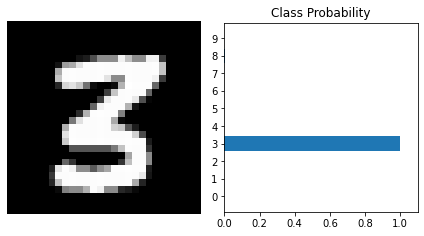

In [53]:
dataiter = iter(testloader)
images.labels = dataiter.next()


idx = 8
logps  = model.forward(images[idx])
ps = torch.exp(logps)

view_classify(images[idx], ps)